# Aceleration comparisons

In [266]:
# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchquad as tquad
from mascon_cube import geodesynet
from mascon_cube.constants import GROUND_TRUTH_DIR, OUTPUT_DIR, VAL_DATASETS_DIR
from mascon_cube.data.mascon_model import MasconModel
from mascon_cube.data.mesh import get_mesh, is_outside_torch, unpack_triangle_mesh
from mascon_cube.data.stokes import combine_stokes_coefficients, mascon2stokes
from mascon_cube.training import CubeTrainingConfig, ValidationConfig, training_loop
from mascon_cube.visualization import plot_mascon_cube, stokes_boxplot, stokes_heatmap
from mascon_cube.metrics import compute_acceleration, cosine_distance, norm_distance, relative_norm_distance
from mascon_cube.data.loading import load_dataset
from matplotlib import pyplot as plt
from torch import nn
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
torch.manual_seed(42)
np.random.seed(42)
device = "cuda"

In [268]:
asteroids = [f.name for f in GROUND_TRUTH_DIR.iterdir() if f.is_dir()]
df = {}

## Compute acelerations

Compute accelerations for ground-truth models

In [269]:
gt_acc = {}
for asteroid in tqdm(asteroids):
    model = MasconModel(asteroid, device=device)
    test_dataset = load_dataset(asteroid, test=True, device=device)
    gt_acc[asteroid] = compute_acceleration(model, test_dataset)

100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Compute accelerations for mascon cubes

In [ ]:
df["MasconCube"] = {}
for asteroid in tqdm(asteroids):
    df["MasconCube"][asteroid] = {}
    cube = torch.load(OUTPUT_DIR / "mascon_cube" / asteroid / "model.pt").to(device)
    test_dataset = load_dataset(asteroid, test=True, device=device)
    cube_acc = compute_acceleration(model, test_dataset)
    for distance_name, distance_fn in zip(("Cosine Distance", "Euclidean Norm Distance", "Relative Euclidean Norm Distance"), (cosine_distance, norm_distance, relative_norm_distance)):
        distance = distance_fn(cube_acc, gt_acc[asteroid])
        df["MasconCube"][asteroid][distance_name] = distance.mean().item()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


Compute accelerations for geodesynets and uniform model

In [271]:
df["GeodesyNet"] = {}
df["Uniform model"] = {}
for asteroid in tqdm(asteroids):
    encoding = geodesynet.direct_encoding()
    net = geodesynet.init_network(encoding, n_neurons=100, model_type="siren", activation=nn.Tanh()).to(device)
    net.load_state_dict(torch.load(OUTPUT_DIR / "geodesynet" / asteroid / "model.pt"))
    net = net.to(device)
    with open(OUTPUT_DIR / "geodesynet" / asteroid / "c.txt", "r") as f:
        c = f.readline()
    c = float(c)
    test_dataset = load_dataset(asteroid, test=True, device=device)
    uniform_model = MasconModel(asteroid, device=device, uniform=True)
    geodesynet_acc = compute_acceleration(net.to(device), test_dataset, batch_size=100, uniform_model=uniform_model.to(device), c=c)
    for distance_name, distance_fn in zip(("Cosine Distance", "Euclidean Norm Distance", "Relative Euclidean Norm Distance"), (cosine_distance, norm_distance, relative_norm_distance)):
        distance = distance_fn(geodesynet_acc, gt_acc[asteroid])
        df["GeodesyNet"][distance_name] = distance.mean().item()
    uniform_acc = compute_acceleration(uniform_model, test_dataset)
    for distance_name, distance_fn in zip(("Cosine Distance", "Euclidean Norm Distance", "Relative Euclidean Norm Distance"), (cosine_distance, norm_distance, relative_norm_distance)):
        distance = distance_fn(uniform_acc, gt_acc[asteroid])
        df["Uniform model"][distance_name] = distance.mean().item()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


In [272]:
df = pd.DataFrame(df)

## Compare accelerations

In [273]:
df

,MasconCube,GeodesyNet,Uniform model
Cosine Distance,6.198883e-09,0.000141,0.016955
Euclidean Norm Distance,0.000000e+00,0.003274,0.134023
Relative Euclidean Norm Distance,0.000000e+00,0.005742,0.187670


In [4]:
def create_dataframe(asteroids):
    df = []
    for asteroid in asteroids:
        with open(GROUND_TRUTH_DIR / asteroid / "stokes.npy", "rb") as f:
            gt_stokes = np.load(f)
        with open(OUTPUT_DIR / "geodesynet" / asteroid / "stokes.npy", "rb") as f:
            net_stokes = np.load(f)
        with open(OUTPUT_DIR / "mascon_cube" / asteroid / "stokes.npy", "rb") as f:
            cube_stokes = np.load(f)
        cube_error = np.abs(gt_stokes - cube_stokes)
        net_error = np.abs(gt_stokes - net_stokes)
        cube_error_rel = np.abs(gt_stokes - cube_stokes) / (np.abs(gt_stokes) + 1e-16)
        net_error_rel = np.abs(gt_stokes - net_stokes) / (np.abs(gt_stokes) + 1e-16)
        for stoke, error, error_rel in zip(cube_stokes.flatten(), cube_error.flatten(), cube_error_rel.flatten()):
            df.append({"asteroid": asteroid, "stoke": stoke, "error": error, "error_rel": error_rel, "model": "cube"})
        for stoke, error, error_rel in zip(net_stokes.flatten(), net_error.flatten(), net_error_rel.flatten()):
            df.append({"asteroid": asteroid, "stoke": stoke, "error": error, "error_rel": error_rel, "model": "net"})
    return pd.DataFrame(df)


In [5]:
df = create_dataframe(asteroids)

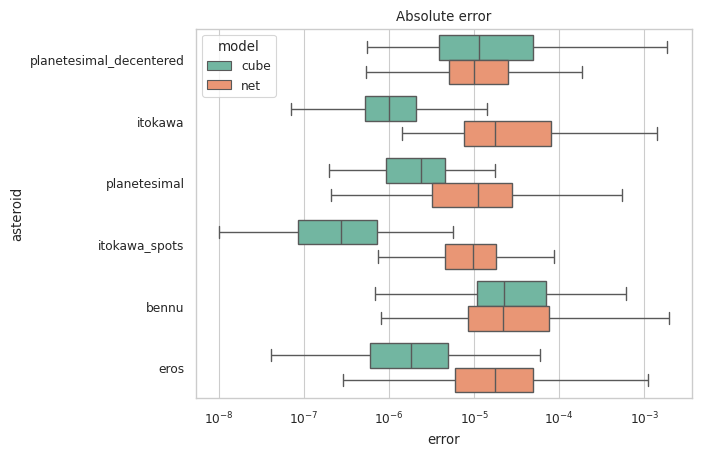

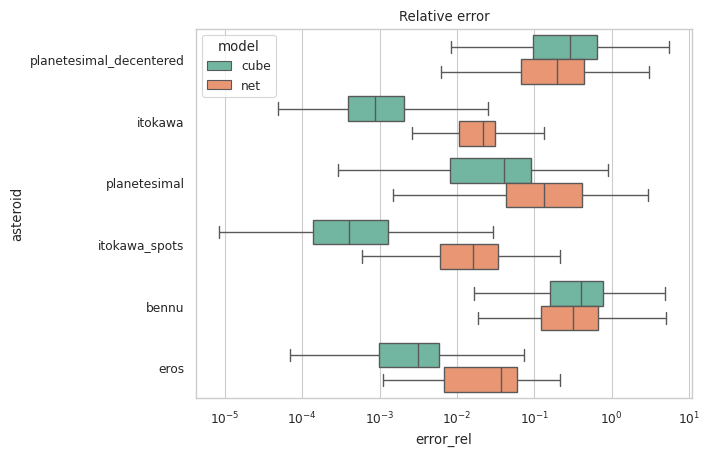

In [6]:
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

sns.boxplot(data=df, y="asteroid", x="error", hue="model", showfliers=False, palette="Set2", orient="h", log_scale=True)
plt.title("Absolute error")
plt.show()
sns.boxplot(data=df, y="asteroid", x="error_rel", hue="model", showfliers=False, palette="Set2", orient="h", log_scale=True)
plt.title("Relative error")
plt.show()